In [13]:
#Library imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import shutil

#Image processing
from skimage.transform import rotate
from skimage import io
import cv2 as cv

#Model deployment
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [14]:
train_data = pd.read_csv('train_labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test_path = 'test/'
train_path = 'train/'
test_data = pd.DataFrame({'id':os.listdir(test_path)})

# removing this training image because it caused a training error previously
train_data[train_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this training image because it's not visible
train_data[train_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(train_data.shape)

(220025, 2)


In [15]:
# declare constants for reproduciblity
RANDOM_STATE = 101

In [16]:
# set model constants
BATCH_SIZE = 256

In [17]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [18]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.15)

In [19]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.


In [20]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 33003 validated image filenames belonging to 2 classes.


In [21]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [22]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #create model
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3) 
    
    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

#quick look at model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 conv2d_6 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 30, 30, 16)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (256, 30, 30, 16)         0         
                                                                 
 batch_normalization_2 (Batc  (256, 30, 30, 16)        64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (256, 28, 28, 32)        

In [23]:
EPOCHS = 25

# train model
history_model = model.fit(train_generator,
                          epochs = EPOCHS,
                          validation_data = valid_generator)

Epoch 1/25


2022-11-29 19:01:51.802378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


731/731 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7935 - auc_1: 0.8646

2022-11-29 19:03:08.561741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


731/731 [==============================] - 90s 122ms/step - loss: 0.4497 - accuracy: 0.7935 - auc_1: 0.8646 - val_loss: 0.7454 - val_accuracy: 0.6990 - val_auc_1: 0.8809
Epoch 2/25
731/731 [==============================] - 93s 127ms/step - loss: 0.3900 - accuracy: 0.8302 - auc_1: 0.9006 - val_loss: 0.4754 - val_accuracy: 0.8050 - val_auc_1: 0.8943
Epoch 3/25
731/731 [==============================] - 94s 128ms/step - loss: 0.3711 - accuracy: 0.8394 - auc_1: 0.9110 - val_loss: 0.3890 - val_accuracy: 0.8331 - val_auc_1: 0.9150
Epoch 4/25
731/731 [==============================] - 96s 131ms/step - loss: 0.3571 - accuracy: 0.8461 - auc_1: 0.9178 - val_loss: 0.4050 - val_accuracy: 0.8284 - val_auc_1: 0.9117
Epoch 5/25
731/731 [==============================] - 97s 132ms/step - loss: 0.3473 - accuracy: 0.8502 - auc_1: 0.9224 - val_loss: 0.3722 - val_accuracy: 0.8430 - val_auc_1: 0.9187
Epoch 6/25
731/731 [==============================] - 97s 132ms/step - loss: 0.3378 - accuracy: 0.8553 - a

In [25]:
print(history_model.history)

{'loss': [0.44965046644210815, 0.3899507224559784, 0.37108466029167175, 0.35713744163513184, 0.3473144769668579, 0.3377517759799957, 0.32875484228134155, 0.319070428609848, 0.3087233304977417, 0.2986093759536743, 0.2884865999221802, 0.2811037302017212, 0.2731025815010071, 0.2679087221622467, 0.2639405131340027, 0.25933071970939636, 0.2548774778842926, 0.2509042024612427, 0.24781093001365662, 0.24339045584201813, 0.2414434254169464, 0.23741032183170319, 0.23422394692897797, 0.23252055048942566, 0.22979803383350372], 'accuracy': [0.7934788465499878, 0.8301643133163452, 0.8394466638565063, 0.84613037109375, 0.8502101302146912, 0.8552950620651245, 0.858578085899353, 0.8638769388198853, 0.868657112121582, 0.8731004595756531, 0.8785008788108826, 0.8823079466819763, 0.8861631155014038, 0.8881254196166992, 0.8902000784873962, 0.8922960758209229, 0.8949534893035889, 0.8969372510910034, 0.8979264497756958, 0.9008725881576538, 0.9011025428771973, 0.902840256690979, 0.9045727252960205, 0.906069874

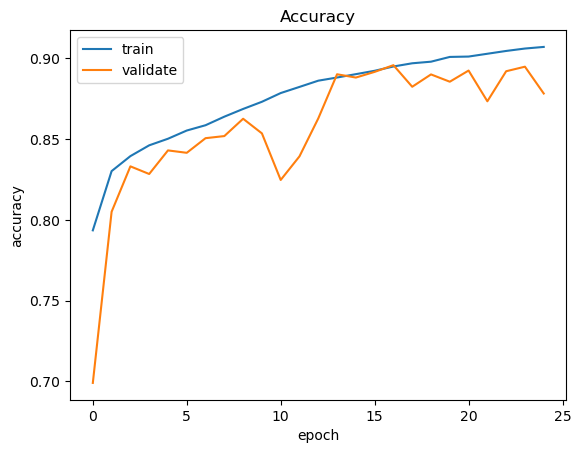

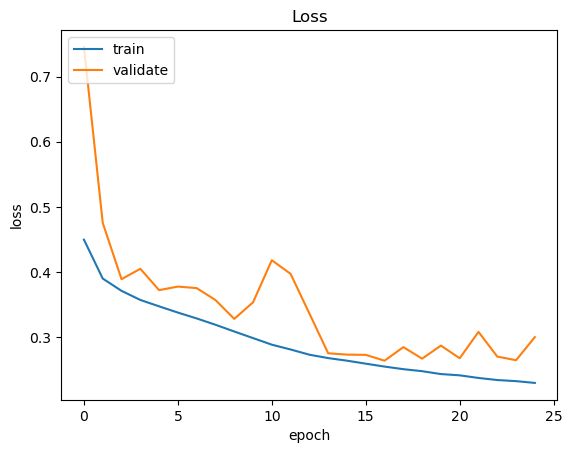

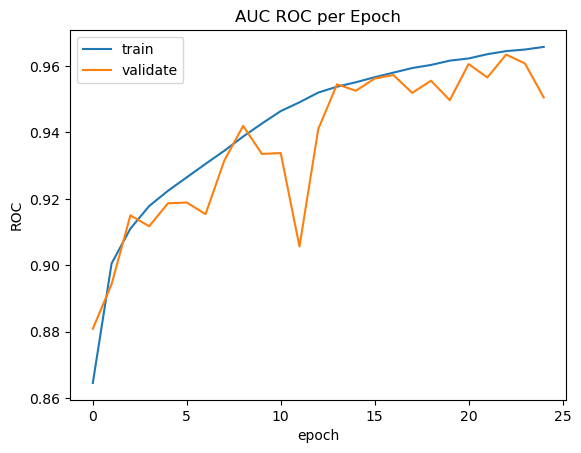

In [26]:
# graph loss
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model.history['auc_1'])
plt.plot(history_model.history['val_auc_1'])
plt.title('AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


In [36]:
# preparing test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [37]:
#creating predictions

predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 116s 2ms/step


In [38]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,1
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [41]:
submission_df['label'].value_counts()

0    35575
1    21883
Name: label, dtype: int64

<AxesSubplot:title={'center':'Image Classification'}, ylabel='label'>

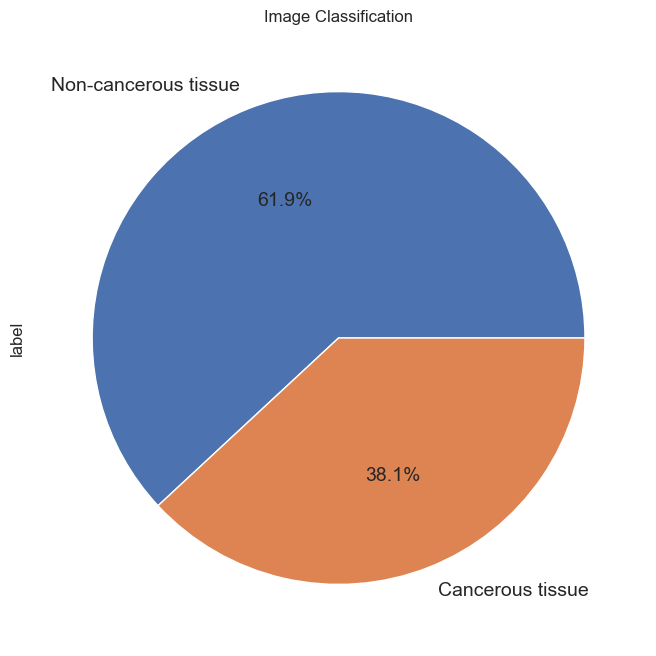

In [43]:
#Submission label percentage
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(submission_df['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Image Classification',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

In [44]:
submission_df.to_csv('final.csv', index=False)